In [105]:
import osmnx as ox
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.collections import LineCollection

ox.config(log_console=True, use_cache=True)
sns.set_style("dark")

exceptions = ['Autopista 25 de Mayo', 'Avenida General Paz']

In [83]:
def centroide(nodes, G):
    xs = [G.nodes[n]['x'] for n in nodes]
    ys = [G.nodes[n]['y'] for n in nodes]
    return np.average(xs), np.average(ys)

In [102]:
def edges_from_place(place):
    G = ox.graph_from_place(place, 'drive')
    calles = defaultdict(lambda: set())
    edges = []
    for n1, n2, data in iter(G.edges.data()):
        if 'name' not in data:
            continue
        if type(data['name']) is not str:
            continue
        calles[data['name']].add(n1)
        calles[data['name']].add(n2)
        edges.append((n1, n2, data))

    centroides = {}
    for k, ns in calles.items():
        c = centroide(ns, G)
        centroides[k] = c
    return G, edges, centroides

In [137]:
font = {'family':'Sans', 'size': 13}
def plot_lines(ax, G, edges, centroides, title):
    lines = []

    for u, v, data in edges:
        cx, cy = centroides[data['name']]
        if data['name'] in exceptions:
            continue
        elif 'geometry' in data:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            xs = map(lambda x: x - cx, xs)
            ys = map(lambda y: y - cy, ys)
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x'] - cx
            y1 = G.nodes[u]['y'] - cy
            x2 = G.nodes[v]['x'] - cx
            y2 = G.nodes[v]['y'] - cy
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    coords = [p for l in lines for p in l]
    east, north = np.max(coords, axis=0)
    west, south = np.min(coords, axis=0)

    ax.axis('off')
    ax.set_ylim([south, north])
    ax.set_xlim([west, east])
    ax.set_title(title, fontdict=font)


    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors='#333333', linewidths=1, alpha=0.1)
    ax.add_collection(lc)

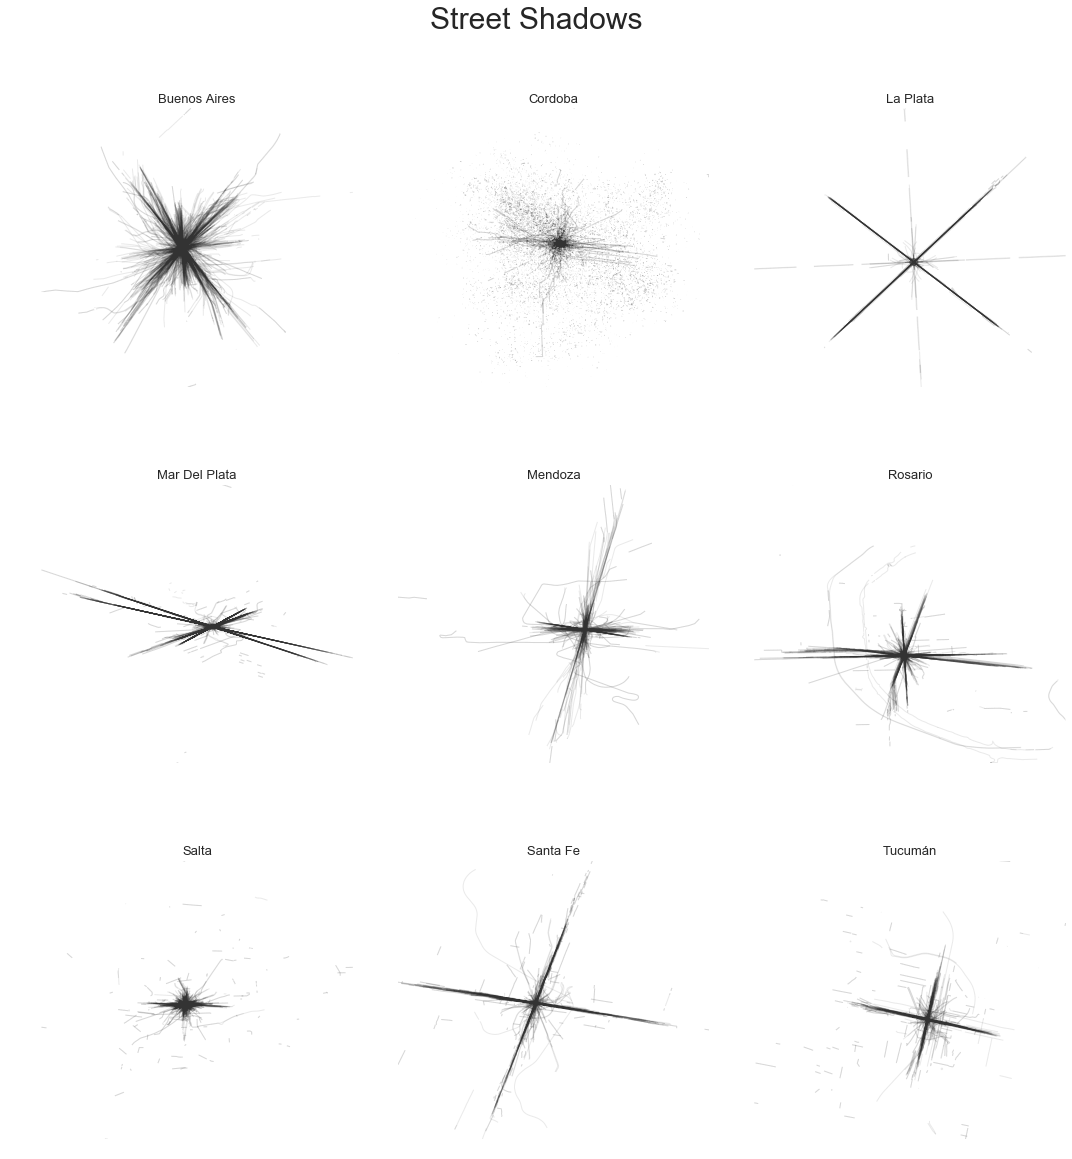

In [139]:
places = {
    'Buenos Aires': 'Buenos Aires, Argentina',
    'Cordoba': 'Cordoba, Argentina',
    'La Plata': 'La Plata, Argentina',
    'Cordoba': 'Cordoba, Argentina',
    'Mar Del Plata': 'Mar Del Plata, Argentina',
    'Mendoza': 'Ciudad de Mendoza, Argentina',
    'Rosario': 'Rosario, Argentina',
    'Salta': 'Salta, Argentina',
    'Santa Fe': 'Santa Fe, Argentina',
    'Tucumán': 'Tucumán, Argentina',
}
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
axes = [y for x in axes for y in x]

# compute graphs, edges and centroids
#datoids = []
#for place, query in sorted(places.items()):
#    datoids.append(edges_from_place(query))

# plot each city
for ax, place, data in zip(axes, sorted(places.keys()), datoids):
    G, edges, centroides = data
    plot_lines(ax, G, edges, centroides, place)

suptitle_font = {'fontsize':30, 'fontweight':'normal', 'y':1.07}
fig.suptitle('Street Shadows', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
plt.gcf().savefig('result.png', dpi=150, bbox_inches='tight')
plt.show()